# 07 - Classification with Support Vector Machines

We will be using the wine quality data set for this notebook. This data set contains various chemical properties of wine, such as acidity, sugar, pH, and alcohol. It also contains a quality metric (3-9, with highest being better) and a color (red or white). In this notebook, we will train a model to predict the color of the wine from the features, which is therefore a binary classification problem.

After some typical processing (in task 1), the first part (task 2 and 3) explores the decision boundaries for a linear support vector machine, and support vector machines with the Gaussian radial basis function kernel. It is then your task to construct a model for binary classification to predict the color of the wine.

**Note:** This notebook is not so heavily commented anymore, since many procedures from previous notebooks are repeated already.

In [1]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

## Task 1: Load, Examine, and Pre-process Data

* Import the data.
* Create the target variable `y` as a 1/0 column where 1 means red.
* Create a `pairplot` for the dataset.
* Create a bar plot showing the correlations between each column and `y`
* Pick the most 2 correlated fields (using the absolute value of correlations) and create `X`
* Use MinMaxScaler to scale `X`. Note that this will output a np.array. Make it a DataFrame again and rename the columns appropriately.

In [2]:
from pathlib import Path
import os

data_dir = str(Path.home()) + r'/coursematerial/GIS/GeoDataScience'

filepath = os.path.join(data_dir, r'WineQuality.csv')

print(filepath)

/home/jovyan/coursematerial/GIS/GeoDataScience/WineQuality.csv


In [3]:
data = pd.read_csv(filepath, sep=',')

Extract the color column as the target variable, and convert it to values 1 (for red) and 0 (for white).

In [4]:
y = (data['color'] == 'red').astype(int)

Calculate the correlations of all fields with the target variable.

In [5]:
fields = list(data.columns[:-1]) # everything except "color"
correlations = data[fields].corrwith(y)
correlations.sort_values(inplace=True)
correlations

total_sulfur_dioxide   -0.700357
free_sulfur_dioxide    -0.471644
residual_sugar         -0.348821
citric_acid            -0.187397
quality                -0.119323
alcohol                -0.032970
pH                      0.329129
density                 0.390645
fixed_acidity           0.486740
sulphates               0.487218
chlorides               0.512678
volatile_acidity        0.653036
dtype: float64

Make pair-plots of all features.

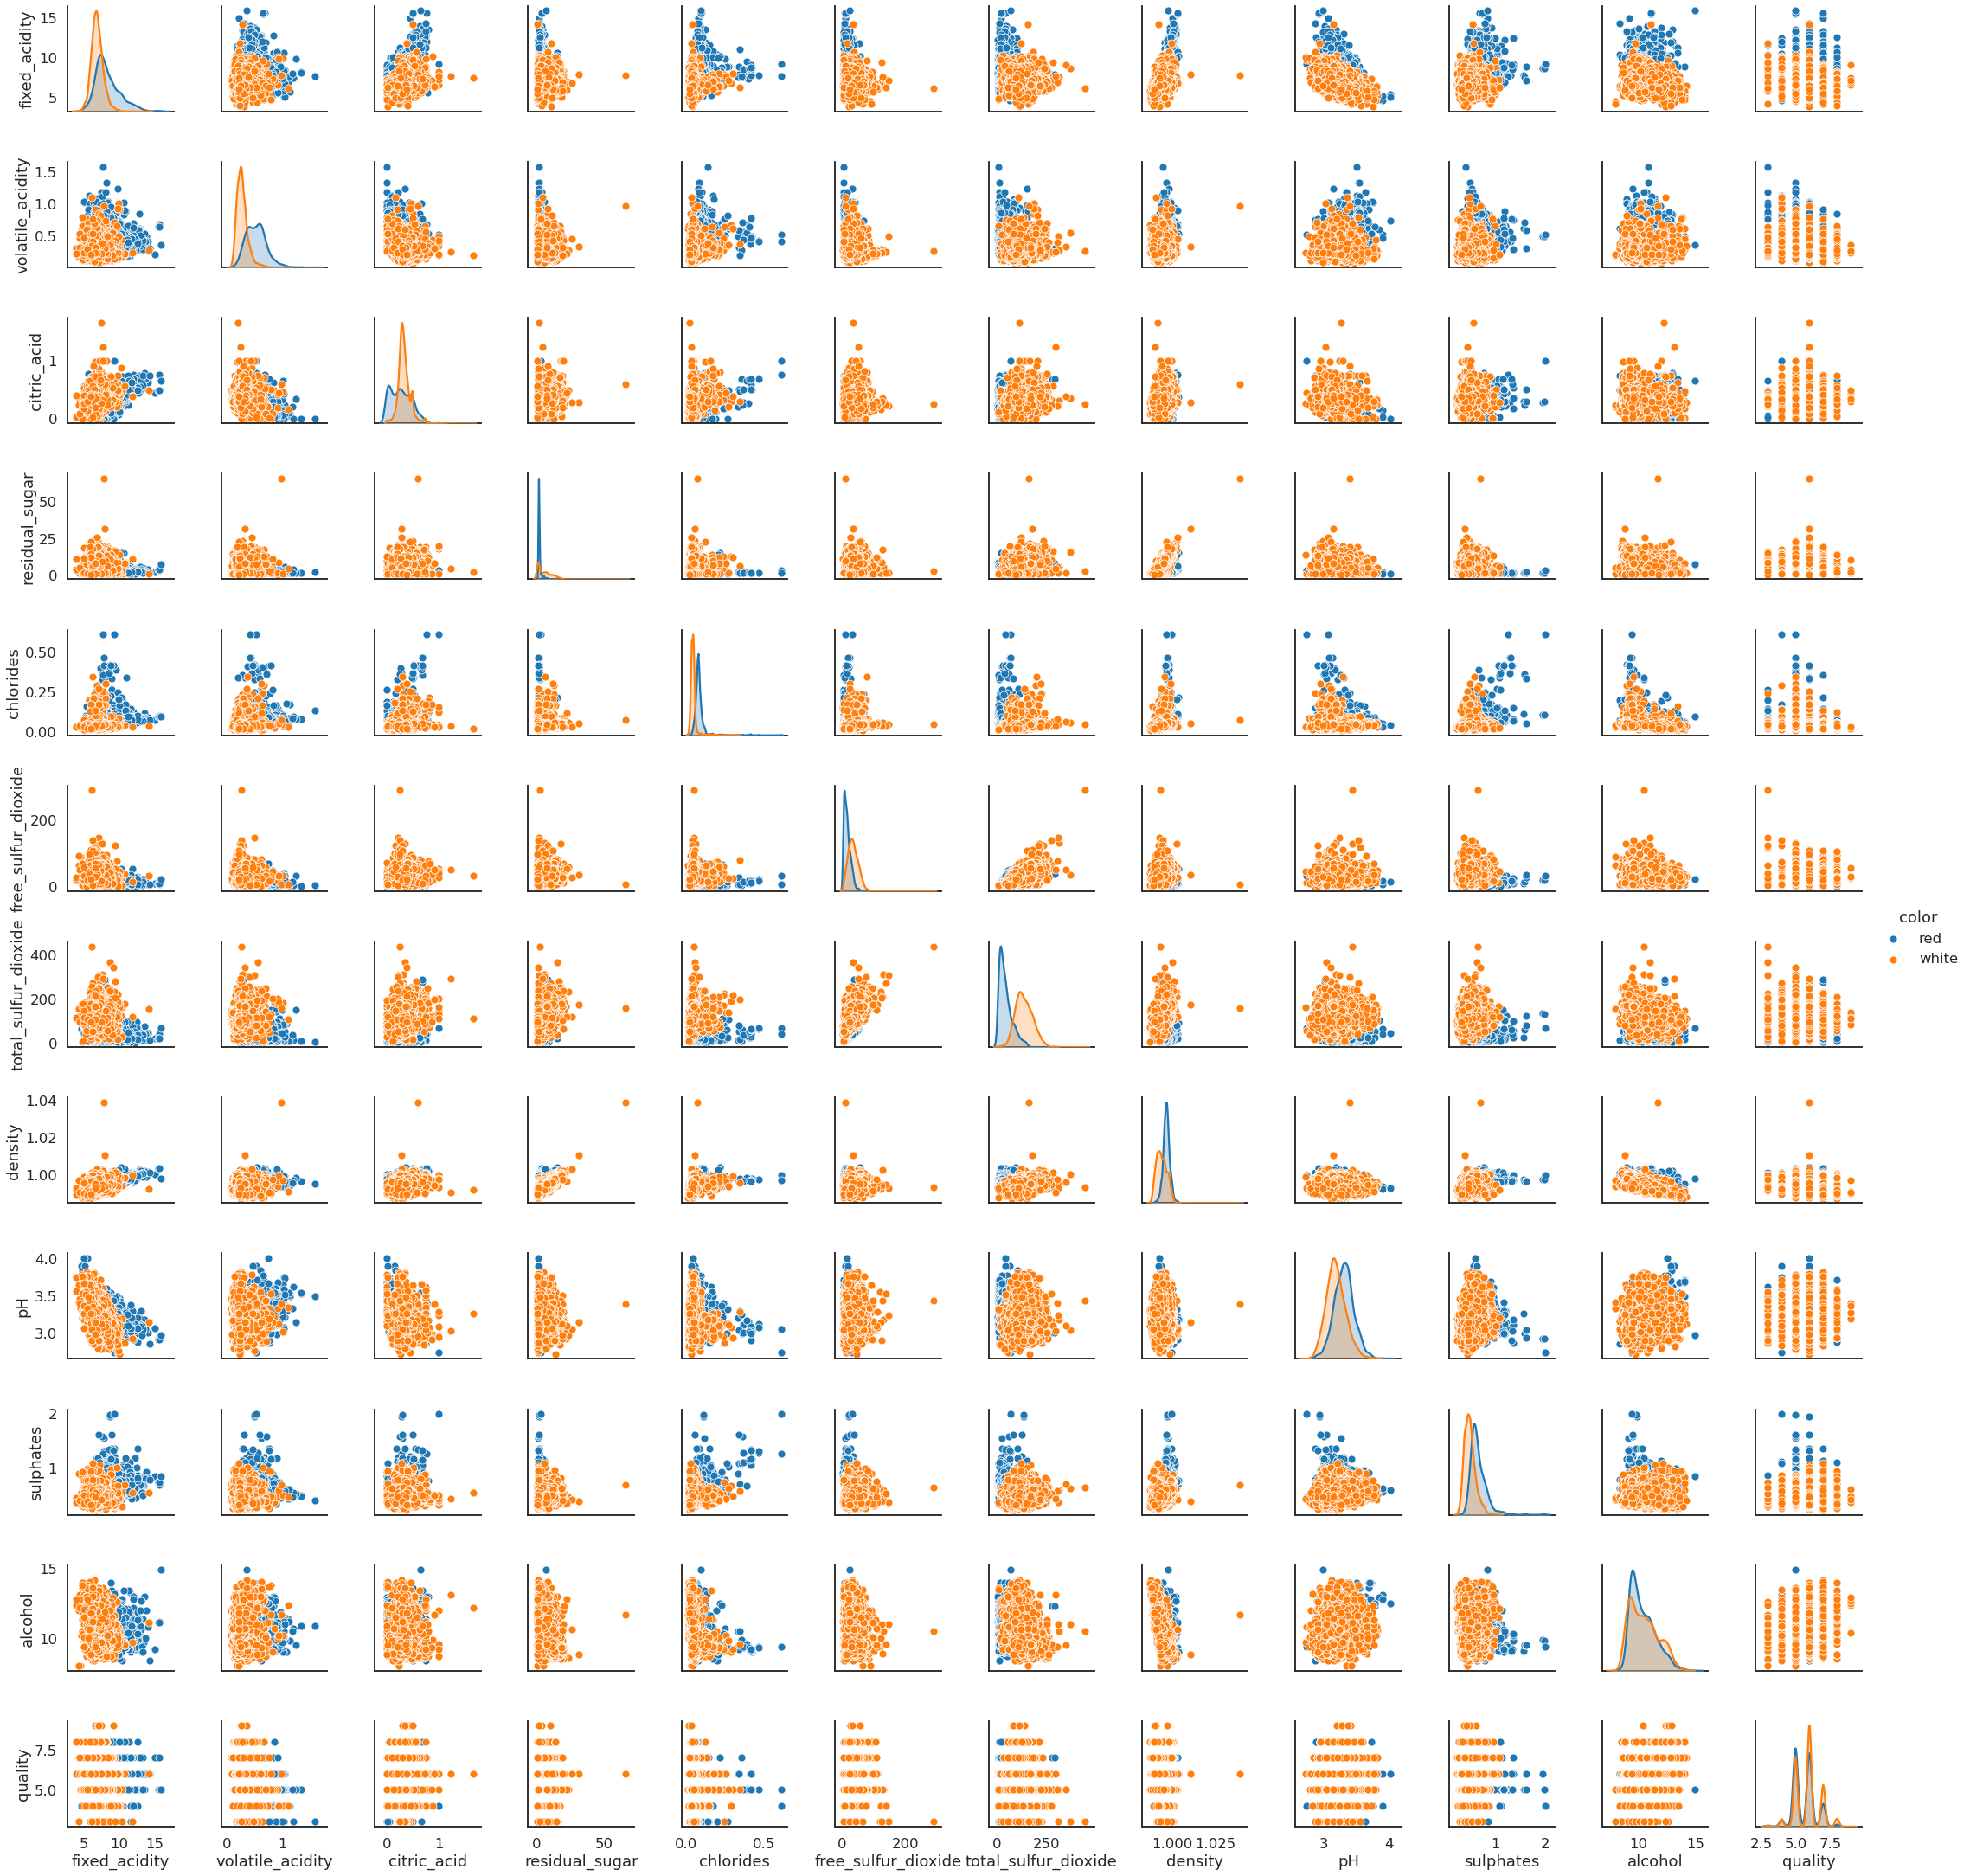

In [6]:
sns.set_context('talk')
sns.set_style('white')
sns.pairplot(data, hue='color')

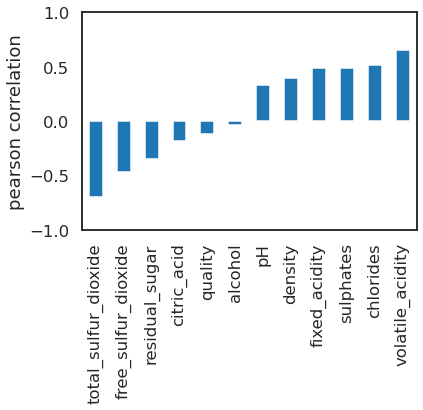

In [7]:
 ax = correlations.plot(kind='bar')
ax.set(ylim=[-1, 1], ylabel='pearson correlation');

In [8]:
from sklearn.preprocessing import MinMaxScaler
fields = correlations.map(abs).sort_values().iloc[-2:].index
print(fields)
X = data[fields]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=['%s_scaled' % fld for fld in fields])
print(X.columns)

Index(['volatile_acidity', 'total_sulfur_dioxide'], dtype='object')
Index(['volatile_acidity_scaled', 'total_sulfur_dioxide_scaled'], dtype='object')


## Task 2: Linear Decision Boundary

Our goal is to look at the decision boundary of a LinearSVM classifier on this dataset. You might want to also check out [this example](https://scikit-learn.org/stable/modules/svm.html) in sklearn's documentation. 

* Fit a Linear Support Vector Machine Classifier (**LinearSVC**) to `X`, `y`.
* Pick 300 samples from `X`. Get the corresponding `y` value. Store them in variables `X_color` and `y_color`. This is because the original dataset is too large and it produces a crowded plot.
* Modify `y_color` so that it has the value 'red' instead of 1 and 'yellow' instead of 0.
* Scatter plot X_color's columns. Use the keyword argument "color=y_color" to color code samples.
* Plot the decision surface in a color coded way.

With the **LinearSVC** class, it is easy to experiment with different parameter choices and see the decision boundary.

In [9]:
from sklearn.svm import LinearSVC
LSVC = LinearSVC()
LSVC.fit(X, y)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Make a plot of the (sampled) dataset, calculate the predictions for the grid (basically the pixels) of the plot, and label the plot accordingly.

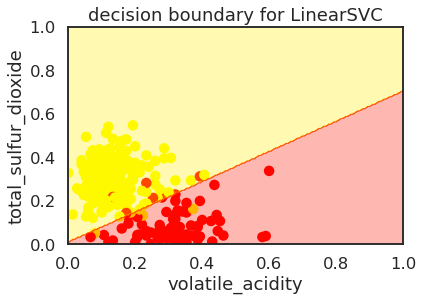

In [10]:
X_color = X.sample(300, random_state=45)
y_color = y.loc[X_color.index]
y_color = y_color.map(lambda r: 'red' if r == 1 else 'yellow')
ax = plt.axes()
ax.scatter(
    X_color.iloc[:, 0], X_color.iloc[:, 1],
    color=y_color, alpha=1)

# -----------

x_axis, y_axis = np.arange(0, 1.005, .005), np.arange(0, 1.005, .005)
xx, yy = np.meshgrid(x_axis, y_axis)
xx_ravel = xx.ravel()
yy_ravel = yy.ravel()
X_grid = pd.DataFrame([xx_ravel, yy_ravel]).T
y_grid_predictions = LSVC.predict(X_grid)
y_grid_predictions = y_grid_predictions.reshape(xx.shape)
ax.contourf(xx, yy, y_grid_predictions, cmap=plt.cm.autumn_r, alpha=.3)

# -----------

ax.set(
    xlabel=fields[0],
    ylabel=fields[1],
    xlim=[0, 1],
    ylim=[0, 1],
    title='decision boundary for LinearSVC');

## Task 3: Gaussian Kernel

Let's now fit a Gaussian radial basis function kernel SVC and see how the decision boundary changes for two features. (Of course, the data has more features which play into account in the decision boundary, but two features are the most we can plot in a 2D plot.)

* Consolidate the code snippets from task 2 into one function which takes an estimator, `X` and `y`, and produces the final plot with decision boundary. The steps are:
    <ol>
     <li> fit model
     <li> get sample 300 records from X and the corresponding y's
     <li> create grid, predict, plot using ax.contourf
     <li> add on the scatter plot
    </ol>
* After copying and pasting code, the finished function uses the input `estimator` and not the LinearSVC model.
* For the following values of `gamma`, create a Gaussian Kernel SVC and plot the decision boundary.  
`gammas = [.5, 1, 2, 10]`
* Holding `gamma` constant, we plot the decision boundary for various values of `C`: 
`[.1, 1, 10]`

In [11]:
def plot_decision_boundary(estimator, X, y):
    estimator.fit(X, y)
    X_color = X.sample(300)
    y_color = y.loc[X_color.index]
    y_color = y_color.map(lambda r: 'red' if r == 1 else 'yellow')
    x_axis, y_axis = np.arange(0, 1, .005), np.arange(0, 1, .005)
    xx, yy = np.meshgrid(x_axis, y_axis)
    xx_ravel = xx.ravel()
    yy_ravel = yy.ravel()
    X_grid = pd.DataFrame([xx_ravel, yy_ravel]).T
    y_grid_predictions = estimator.predict(X_grid)
    y_grid_predictions = y_grid_predictions.reshape(xx.shape)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.contourf(xx, yy, y_grid_predictions, cmap=plt.cm.autumn_r, alpha=.3)
    ax.scatter(X_color.iloc[:, 0], X_color.iloc[:, 1], color=y_color, alpha=1)
    ax.set(
        xlabel=fields[0],
        ylabel=fields[1],
        title=str(estimator))

Use different gamma values for the model and plot the decision boundaries.

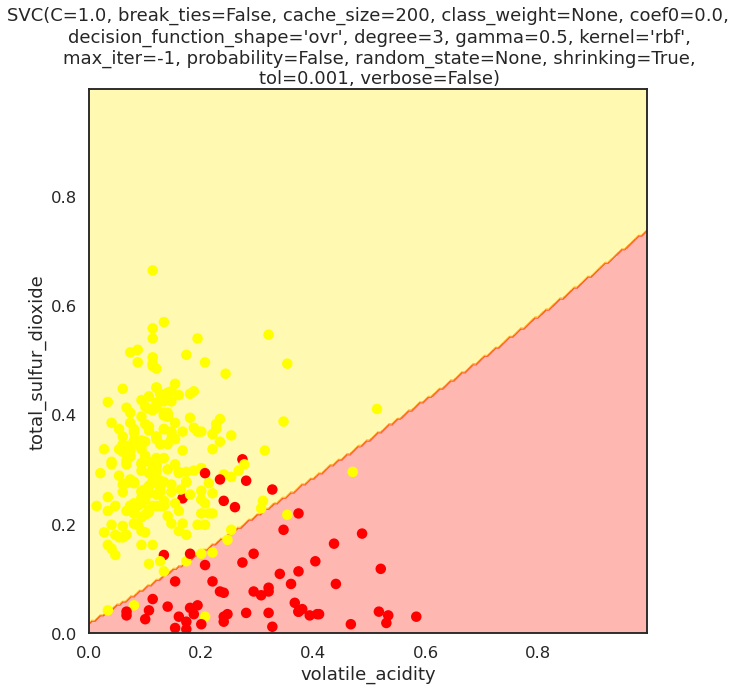

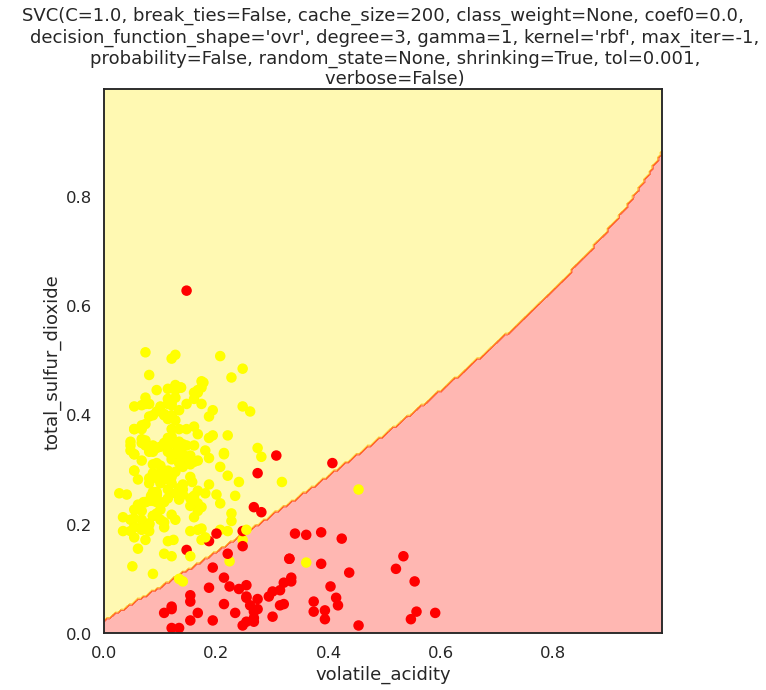

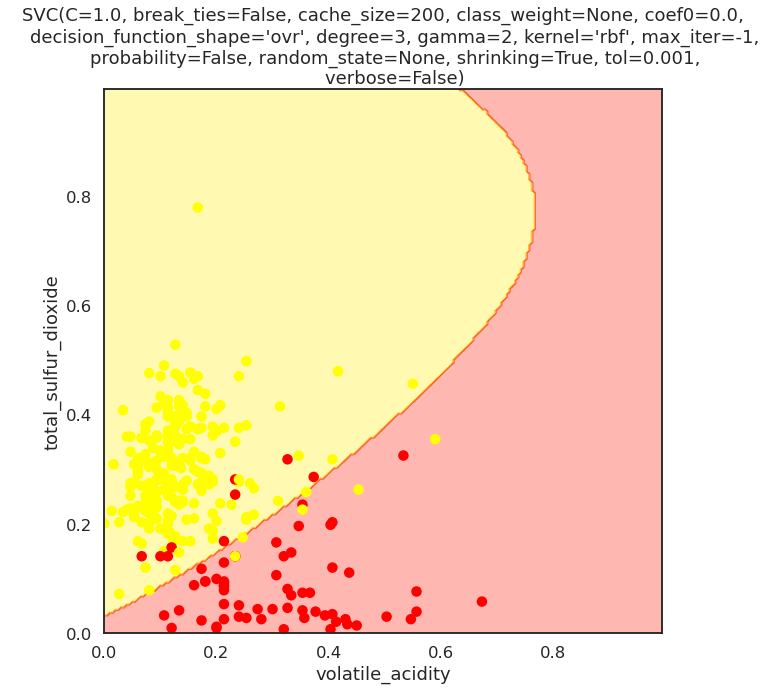

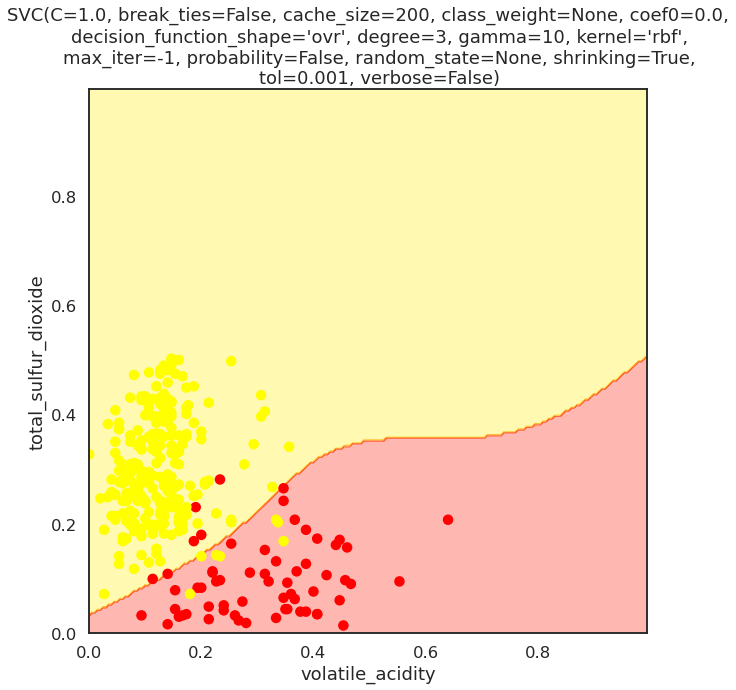

In [12]:
from sklearn.svm import SVC
gammas = [.5, 1, 2, 10]
for gamma in gammas:
    SVC_Gaussian = SVC(kernel='rbf', gamma=gamma)
    plot_decision_boundary(SVC_Gaussian, X, y)

Now, use different values for the hyperparameter C (that penalizes margin violations), but keep gamma the same (at 2.0).

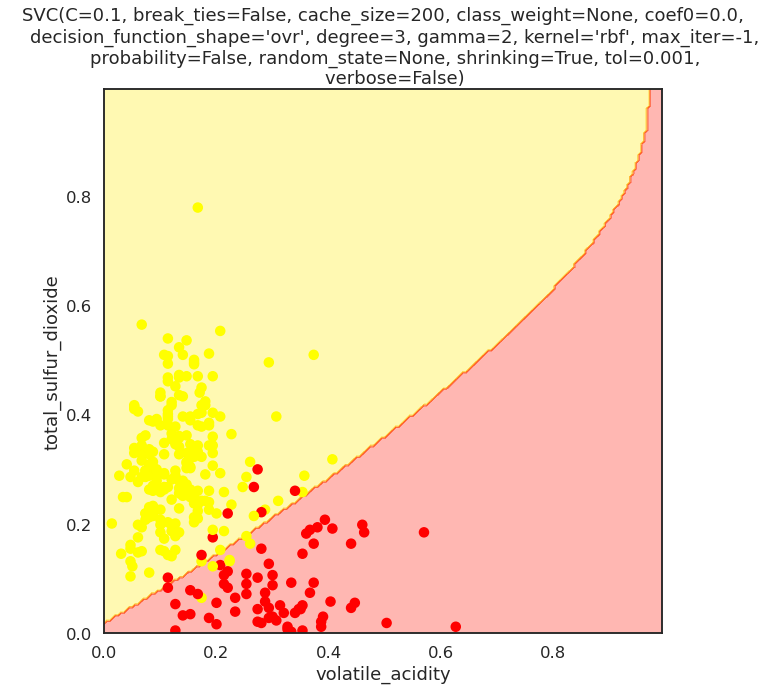

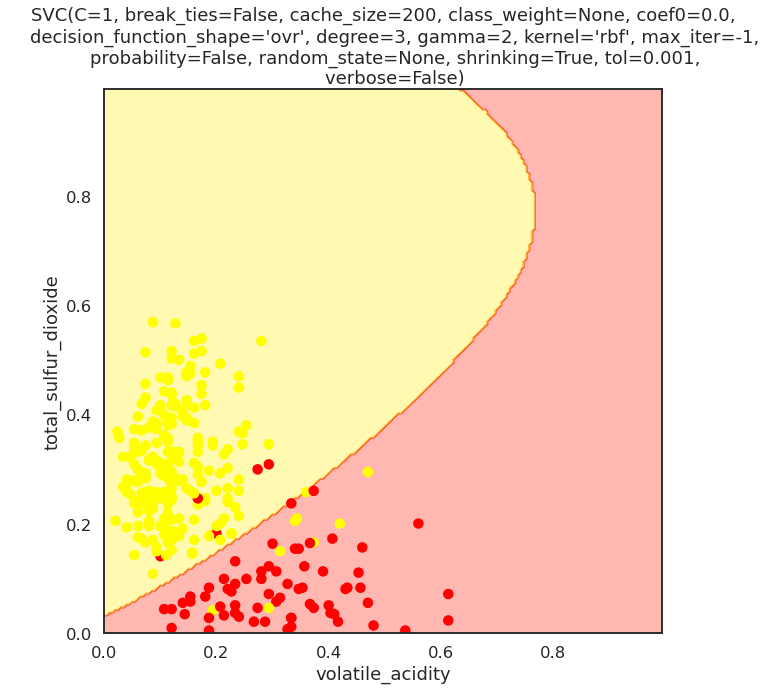

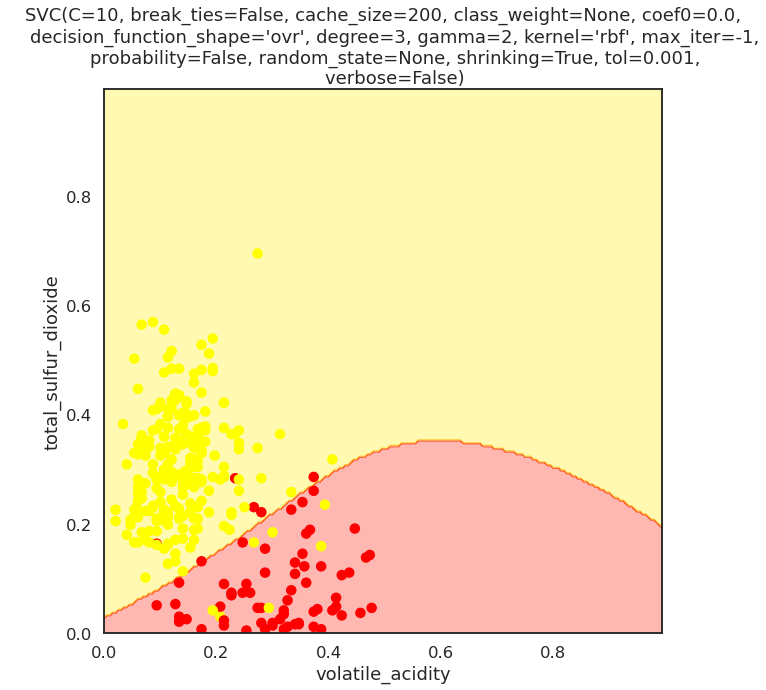

In [13]:
from sklearn.svm import SVC
Cs = [0.1,1, 10]
gamma=2
for C in Cs:
    SVC_Gaussian = SVC(kernel='rbf', gamma=gamma,C=C)
    plot_decision_boundary(SVC_Gaussian, X, y)

## Task 4: Fit and Evaluate a SVC Model

From the observations of the plots above:
- Construct a new SVC model
- Split the dataset into training and testing
- Train the model with the given data
- Make predictions
- Evaluate the performance with some metrics (like in the multinomial logistic regression notebook)

What accuracy could you reach?

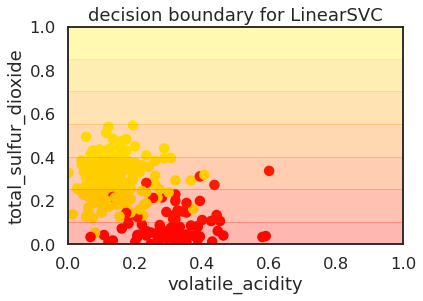

In [31]:
from sklearn.svm import SVC
SVC_Gaussian = SVC(kernel='rbf', gamma=10)
SVC_Gaussian.fit(X,y)

X_color = X.sample(300, random_state=45)
y_color = y.loc[X_color.index]
y_color = y_color.map(lambda r: 'red' if r == 1 else 'yellow')
ax = plt.axes()
ax.scatter(
    X_color.iloc[:, 0], X_color.iloc[:, 1],
    color=y_color, alpha=1)

# -----------

x_axis, y_axis = np.arange(0, 775), np.arange(0, 775)
xx, yy = np.meshgrid(x_axis, y_axis)
xx_ravel = xx.ravel()
yy_ravel = yy.ravel()
X_grid = pd.DataFrame([xx_ravel, yy_ravel]).T
y_grid_predictions = SVC_Gaussian.predict(X_grid)
y_grid_predictions = y_grid_predictions.reshape(xx.shape)
ax.contourf(xx, yy, y_grid_predictions, cmap=plt.cm.autumn_r, alpha=.3)

# -----------

ax.set(
    xlabel=fields[0],
    ylabel=fields[1],
    xlim=[0, 1],
    ylim=[0, 1],
    title='decision boundary for LinearSVC');


In [29]:
y[0:201].shape
SVC_Gaussian.support_.shape

(775,)

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y[SVC_Gaussian.support_], y_grid_predictions))


ValueError: Found input variables with inconsistent numbers of samples: [775, 201]